### Import data

In [53]:
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import os.path
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import minimize
from DATA import get_filtered_stock_data as gfs
from DATA import read_data
from Effient_Frontier import get_cov_mean_matrices
from Effient_Frontier import efficient_frontier

In [76]:
#stock_data = None
file_path = "ESG_DATA.csv"
esg = read_data(file_path)
column_name = 'environment_score'
column_value = 'High'
threshold = 500
operator = 'geq'
prefixes= ['SE', 'DK','NO']
start_date = '2015-01-01'
end_date = '2021-04-30'

In [77]:
returns = gfs(file_path, column_name, column_value, prefixes, start_date, end_date, time='y', threshold=threshold, operator=operator)

In [69]:
mu = get_cov_mean_matrices(returns)[1]
cov = get_cov_mean_matrices(returns)[0]
target = np.linspace(np.min(mu), np.max(mu), 100)
rf = 0.00
bounds = [(0, 1) for _ in range(len(mu))]
score = 'environment_score'

In [37]:
eff = efficient_frontier(mu, cov, target, rf, bounds, esg, returns, score)
%time

CPU times: total: 0 ns
Wall time: 0 ns


In [38]:
max_sharpe_ret = eff[0]
max_sharpe_vol = eff[1]
max_sharpe_sr = eff[2]
portfolio_esg = eff[3]
print(portfolio_esg)
fron=eff[4]
mu = eff[5]
stdevs_ = eff[6]

[439.91997473323204]


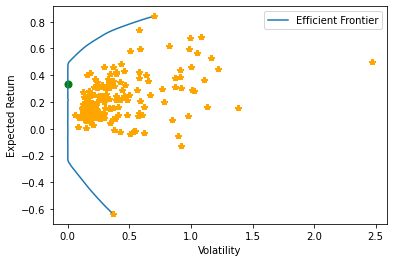

In [39]:
# Plot the efficient frontier and Sharpe ratio
plt.plot(fron[:,1], fron[:,0], label='Efficient Frontier')
plt.plot(stdevs_, mu, '*', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Plot a red dot at the portfolio with the highest Sharpe ratio
plt.scatter(max_sharpe_vol, max_sharpe_ret, marker='o', color='g', s=50, label='Max Sharpe Ratio')
plt.show()

Text(0, 0.5, 'Sharpe Ratio')

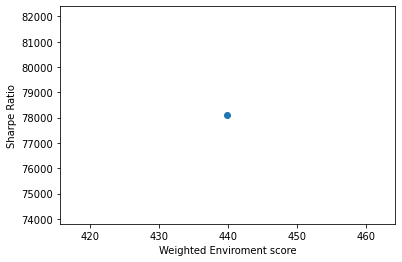

In [40]:
plt.scatter(portfolio_esg, max_sharpe_sr)
plt.xlabel('Weighted Enviroment score')
plt.ylabel('Sharpe Ratio')

#### Martin kode

In [78]:
mean_matrix = np.array(returns.mean())
cov_matrix = np.array(returns.cov())
#print(cov_matrix )


# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
 
# All dataframes hereafter reflect these changes.
display(returns.cov())
display(returns.mean())
 
# Resets the options
pd.reset_option('all')


C:\Users\Bruger\AppData\Local\Temp\ipykernel_5172\1629681798.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,SE0000106205,SE0000108847,SE0000114837,SE0000115420,SE0000148884,SE0000163594,SE0000190126,SE0000191090,SE0000375115,SE0000418923,SE0000695876,SE0000862997,SE0000872095,SE0000936478,SE0000949331,SE0001279142,SE0001515552,SE0001790791,SE0001834821,SE0004635878,SE0005190220,SE0007074281,SE0007666110,SE0007691613,SE0007871645,SE0010100958,SE0011090000,SE0011166974,SE0011205202,SE0011337708,SE0014504817,SE0014781795,SE0015962477,SE0015988019,SE0018012486,SE0018013849,DK0010219070,DK0010234467,DK0010263722,DK0010267129,DK0010272202,DK0010272632,DK0010311471,DK0060520450,DK0060522746,DK0060542181,DK0060634707,DK0060655629,DK0060854669,DK0060946788,NO0003033102,NO0003053605,NO0003079709,NO0003095309,NO0003097503,NO0003103103,NO0003399909,NO0003572802,NO0004913609,NO0005806802,NO0010000045,NO0010081235,NO0010205966,NO0010208051,NO0010252356,NO0010257728,NO0010262686,NO0010272065,NO0010307135,NO0010317316,NO0010598683,NO0010612450,NO0010629108,NO0010708068,NO0010708910,NO0010716863,NO0010734338,NO0010735343
SE0000106205,0.015392,0.012429,0.009988,-0.003327,0.003713,0.009496,0.003220,0.029243,0.010302,0.007247,0.005637,0.004039,-0.015098,0.018098,0.018270,0.037753,0.004770,0.002953,0.052607,0.013134,0.005804,0.012129,-0.004142,0.009034,-0.003444,0.003989,-0.003897,0.005117,0.005143,0.011438,0.018822,0.010738,-0.023111,0.002615,-0.001873,0.049152,-0.011696,-0.004273,-0.007656,-0.009851,0.000730,-0.011978,0.005356,0.040465,0.011099,0.009187,-0.005178,0.020922,0.009235,-0.040464,-0.036005,0.000568,-0.008062,-0.004363,-0.001081,0.002456,-0.008893,-0.014649,0.004951,0.012529,0.020382,-0.029966,0.025924,0.003613,-0.017695,-0.162176,0.005309,-0.002972,-0.007399,-0.039203,0.008127,0.016626,0.021048,-0.006396,-0.015286,-0.008146,0.006314,0.006499
SE0000108847,0.012429,0.038730,0.031446,0.022775,-0.001467,0.017986,0.017764,0.035230,0.042429,0.040240,0.008982,0.022335,-0.024005,0.037130,0.046934,0.149902,0.032775,0.023859,0.014121,0.022445,0.006413,0.026123,-0.010830,0.039183,0.005694,0.015111,0.029821,0.008528,0.014880,0.025263,0.028490,0.039175,0.034962,0.024497,0.020478,0.101671,0.003245,0.002928,-0.008300,0.013665,0.038991,-0.008450,0.019396,0.162340,0.038314,0.020732,0.006710,0.045919,0.021564,-0.043581,0.004319,0.011020,0.019466,-0.013792,0.034580,-0.003742,-0.007060,-0.030225,0.046759,0.021594,0.013583,0.044427,0.028202,0.010634,-0.047695,-0.061829,-0.022519,-0.027836,0.055696,-0.037651,0.048347,0.033277,-0.027072,0.060809,0.033698,0.040719,0.016424,0.033682
SE0000114837,0.009988,0.031446,0.036307,0.027074,0.008433,0.011655,0.020971,0.053258,0.022283,0.036533,0.009668,0.031938,-0.032533,0.041174,0.044264,0.127832,0.034587,0.005864,0.007814,0.008201,-0.001529,0.026304,-0.002141,0.041576,0.039519,0.015569,0.027099,-0.008847,0.012820,0.016750,0.020192,0.038691,0.045226,0.019921,0.014709,0.068215,0.015330,0.008492,-0.008609,0.005080,0.029266,-0.004806,0.036811,0.179339,0.026158,0.022590,0.001807,0.042615,0.014013,-0.019819,0.020714,0.016343,0.019006,-0.008233,0.027273,0.002329,-0.001068,-0.003953,0.056214,0.016335,-0.007791,0.037221,0.011552,0.015743,-0.046105,-0.006959,-0.020526,-0.027523,0.124160,-0.024111,0.008844,0.013726,0.062243,0.029201,0.064686,0.077972,0.033969,0.038244
SE0000115420,-0.003327,0.022775,0.027074,0.054691,0.011727,-0.006526,0.024270,0.026152,-0.040366,0.046026,0.011886,0.010887,-0.062740,0.027430,0.010370,0.049743,0.025827,0.003360,-0.013728,-0.011460,0.003385,0.010920,0.002781,0.061493,0.008399,-0.000034,0.050353,-0.018699,0.004145,-0.003011,0.014236,0.034606,0.071433,0.011431,0.043633,-0.096317,0.019496,0.026480,0.002516,0.015011,-0.008692,0.019255,0.028702,0.143553,0.019859,-0.000182,0.002900,-0.000782,0.004239,0.001844,0.057680,0.025476,-0.001845,0.042151,-0.004959,-0.004261,0.009023,0.006276,0.057829,-0.013644,-0.043811,-0.016377,0.006900,0.008013,-0.000440,0.346926,0.051970,-0.017255,0.097285,0.030362,0.015058,0.001997,-0.063735,0.141940,0.078330,0.061582,0.014031,0.039430
SE0000148884,0.003713,-0.001467,0.008433,0

SE0000106205    0.183282
SE0000108847    0.180926
SE0000114837    0.139715
SE0000115420    0.201994
SE0000148884    0.099134
SE0000163594    0.116094
SE0000190126    0.161571
SE0000191090    0.155520
SE0000375115    0.431841
SE0000418923    0.372842
SE0000695876    0.152679
SE0000862997    0.128426
SE0000872095    0.144527
SE0000936478    0.146357
SE0000949331    0.109973
SE0001279142    0.439195
SE0001515552    0.313660
SE0001790791    0.582343
SE0001834821    0.101547
SE0004635878    0.414665
SE0005190220    0.134842
SE0007074281    0.126531
SE0007666110    0.004601
SE0007691613    0.197384
SE0007871645    0.217960
SE0010100958    0.277735
SE0011090000    0.242459
SE0011166974    0.186986
SE0011205202    0.399942
SE0011337708    0.185841
SE0014504817    0.110441
SE0014781795    0.323186
SE0015962477    0.349384
SE0015988019    0.309956
SE0018012486    0.253742
SE0018013849    0.291786
DK0010219070    0.242544
DK0010234467    0.066054
DK0010263722    0.232656
DK0010267129    0.233849


C:\Users\Bruger\anaconda3\lib\site-packages\pandas\_config\config.py:645: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\Bruger\anaconda3\lib\site-packages\pandas\_config\config.py:645: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


1.3903927995318927e+18
4.786966062765342e+17
8.637041403317496e+16
-1.090616390963564e+35


C:\Users\Bruger\AppData\Local\Temp\ipykernel_5172\230930840.py:26: RuntimeWarning: invalid value encountered in sqrt
  minstd = np.sqrt(minvar)


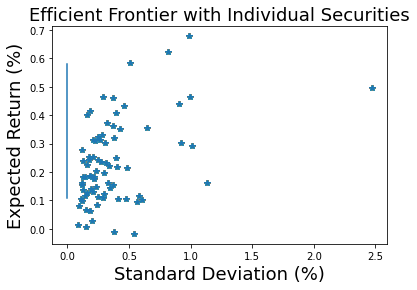

In [79]:
#S = np.array([[185, 86.5, 80, 20],[86.5, 196, 76, 13.5],[80, 76, 411, -19],[20, 13.5, -19, 25]])*100
S = cov_matrix
#zbar = np.array([14, 12, 15, 7])
zbar = mean_matrix
unity = np.ones(len(zbar))

# Calculate standard deviations of securities
stdevs = np.sqrt(np.diag(S))

# Calculate parameters A, B, C, and D for efficient frontier
A = np.dot(unity.T, np.dot(np.linalg.inv(S), unity))
print(A)
B = np.dot(unity.T, np.dot(np.linalg.inv(S), zbar))
print(B)
C = np.dot(zbar.T, np.dot(np.linalg.inv(S), zbar))
print(C)
D = A*C - B**2
print(D)

# Define mu values for efficient frontier
mu = np.linspace(np.min(zbar), np.max(zbar), 100)

# Calculate minimum variance and standard deviation for each mu
minvar = ((A * mu ** 2) - 2 * B * mu + C) / D
# minvar[minvar < 0] = 0    # Ensure minvar is non-negative
minstd = np.sqrt(minvar)

# Repeat stdevs and zbar 300 times to match length of mu and minstd
stdevs_ = np.repeat(stdevs[:, np.newaxis], 100, axis=1)
zbar_ = np.repeat(zbar[:, np.newaxis], 100, axis=1)

# Plot efficient frontier and individual securities
plt.plot(minstd, mu, label='Efficient Frontier')
plt.plot(stdevs_, zbar_, '*', label='Individual Securities')
#plt.legend()
plt.title('Efficient Frontier with Individual Securities', fontsize=18)
plt.ylabel('Expected Return (%)', fontsize=18)
plt.xlabel('Standard Deviation (%)', fontsize=18)
plt.show()

In [66]:
np.linalg.inv(S)

array([[-7.92495443e+16, -7.71113675e+16, -1.14818622e+17, ...,
        -7.15599565e+16,  6.14222486e+16, -2.25739230e+16],
       [ 5.39458870e+16,  2.34560732e+16,  3.74234857e+16, ...,
         3.81918439e+16, -3.04596118e+16,  2.28826226e+16],
       [-4.59224767e+15,  6.58833319e+15,  1.49744174e+16, ...,
         7.81803976e+15, -1.85271389e+16, -4.73521814e+15],
       ...,
       [ 3.94445772e+15,  2.97280671e+15,  2.92970304e+15, ...,
        -6.22061858e+14,  3.78188863e+14,  2.94063015e+15],
       [-7.33238609e+15,  1.72577088e+15, -1.27082542e+15, ...,
        -7.34134177e+13, -4.03608484e+15,  2.27462482e+15],
       [ 1.29954059e+15, -2.46995767e+15, -8.14838445e+14, ...,
        -1.53859289e+15,  2.92431074e+15,  1.64472393e+15]])

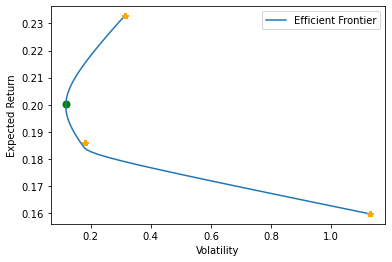

In [72]:
# Define the expected returns and covariance matrix of the assets
mu = mean_matrix
cov = cov_matrix

# Define the objective function to minimize
def objective(weights):
    return np.dot(weights.T, np.dot(cov, weights))

# Define the constraint that the sum of the weights equals 1
def constraint(weights):
    return np.sum(weights) - 1

# Define the bounds for the weights
bounds = [(0, 1) for _ in range(len(mu))]

# Define the risk-free rate
rf = 0

# Define the range of returns to plot
target = np.linspace(np.min(mu), np.max(mu), 100)

#negative sharpe ratio calculator
def negativeSR(w):
    w = np.array(w)
    V = np.sqrt(w.T @ cov @ w)
    R = np.sum(mu *w)
    SR = (R-rf)/V
    return -1*SR

# Define the initial guess for the weights
x0 = np.ones(len(mu)) / len(mu)

# Calculate the efficient frontier
frontier = []
portfolio_esg = []
#weights_list = []
for ret in target:
    # Define the constraint that the expected return of the portfolio equals the desired return
    def ret_constraint(weights):
        return np.dot(weights, mu) - ret
    # Use the minimize function to find the portfolio weights that minimize the objective function subject to the constraints
    res = minimize(objective, x0, method='SLSQP', constraints=[{'type': 'eq', 'fun': constraint}, {'type': 'eq', 'fun': ret_constraint}], bounds=bounds)
    # Calculate the volatility of the portfolio
    #weights_list.append(res.x)
    vol = np.sqrt(res.fun)
    # Calculate the Sharpe ratio of the portfolio
    sharpe = (ret - rf) / vol
    # Append the results to the frontier
    frontier.append((ret, vol, sharpe))

# Convert the frontier to a numpy array
frontier = np.array(frontier)

#find sharpe ratio weights
constraints = ({'type': 'eq', 'fun': constraint})
w_opt = minimize(negativeSR,x0,method='SLSQP',bounds=bounds,constraints=constraints).x



result = 0
for count, col in enumerate(returns.columns):
    #print(type(col))
    first = esg[esg['Isin']==col]
    env = first['environment_score']
    env = env.to_numpy()[0]
    result += w_opt[count] * env

# Find the portfolio with the highest Sharpe ratio
max_sharpe_idx = np.argmax(frontier[:,2])
max_sharpe_ret, max_sharpe_vol, max_sharpe_sr = frontier[max_sharpe_idx]



# Calculate standard deviations of securities
stdevs = np.sqrt(np.diag(cov))
stdevs_ = np.repeat(stdevs[:, np.newaxis], 100, axis=1)
mu = np.repeat(mu[:, np.newaxis], 100, axis=1)

# Plot the efficient frontier and Sharpe ratio
plt.plot(frontier[:,1], frontier[:,0], label='Efficient Frontier')
plt.plot(stdevs_, mu, '*', color='orange')#label='Individual Securities')
#plt.scatter(frontier[:,1], frontier[:,0], c=frontier[:,2]), cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
#plt.colorbar(label='Sharpe Ratio')
plt.legend()

# Plot a red dot at the portfolio with the highest Sharpe ratio
plt.scatter(max_sharpe_vol, max_sharpe_ret, marker='o', color='g', s=50, label='Max Sharpe Ratio')

plt.show()

In [30]:
 res

     fun: 0.09798968790562147
     jac: array([-0.03751515,  0.19597937, -0.24347013])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([5.44269491e-16, 1.00000000e+00, 0.00000000e+00])

In [12]:
test = esg[esg['Isin']=='SE0011337708']
test = test['environment_score']
test = test.to_numpy()[0]
test


647


KeyboardInterrupt

